In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import model_from_json
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import argparse
import glob
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [89]:
mask_image_path = glob.glob("dataset/with_mask/*.jpg")
no_mask_image_path = glob.glob("dataset/without_mask/*.jpg")
print("[INFO] Find {:d} images with mask".format(len(mask_image_path)))
print("[INFO] Find {:d} images without mask".format(len(no_mask_image_path)))

[INFO] Find 690 images with mask
[INFO] Find 686 images without mask


In [90]:
# stack all images in one dataset path
dataset_paths = np.hstack((mask_image_path,no_mask_image_path))

# Create dataset with X as image data and y as class label
X = []
y = []
for image_path in dataset_paths:
    # extract class label
    label = image_path.split(os.path.sep)[-2][8:]
    
    # load image as input size of 224x224
    image = load_img(image_path,target_size=(224,224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    # append image and label to X and y
    X.append(image)
    y.append(label)

# Convert X and y to numpy array
X = np.array(X,dtype="float32")    
y = np.array(y)


In [91]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
y = lb.fit_transform(y)
y = to_categorical(y)

In [0]:
# split 20% of data as validation set
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [0]:
image_augumentation = ImageDataGenerator( rotation_range=20,
                                         zoom_range=0.15,
                                         width_shift_range=0.2, 
                                         height_shift_range=0.2, 
                                         shear_range=0.15, 
                                         horizontal_flip=True, 
                                         fill_mode="nearest")

In [3]:
def create_model(lr=1e-4,decay=1e-4/25, training=False):
    baseModel = MobileNetV2(weights="imagenet", 
                            include_top=False,
                            input_tensor=Input(shape=(224, 224, 3)))
    
    headModel = baseModel.output
    headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(2, activation="softmax")(headModel)
    
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    if training:
        # define trainable alyer
        for layer in baseModel.layers:
            layer.trainable = False
        # compile modle
        optimizer = Adam(lr=lr, decay = decay)
        model.compile(loss="binary_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
    return model

In [12]:
# Create our model with pre-trained MobileNetV2 model on imagenet dataset
# initilaize initial hyperparameter
INIT_LR = 1e-4
EPOCHS = 25

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [13]:
# Train model
BATCH_SIZE = 32

my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=0),
                ModelCheckpoint(filepath="facemask_detection.h5", verbose=1, save_best_only=True)
                ]

result = model.fit(image_augumentation.flow(trainX, trainY, batch_size=BATCH_SIZE), 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer)

Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 0.4524 - accuracy: 0.7914
Epoch 00001: val_loss improved from inf to 0.10275, saving model to facemask_detection.h5
34/34 [==============================] - 13s 385ms/step - loss: 0.4524 - accuracy: 0.7914 - val_loss: 0.1027 - val_accuracy: 0.9674
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9663
Epoch 00002: val_loss improved from 0.10275 to 0.05811, saving model to facemask_detection.h5
34/34 [==============================] - 12s 352ms/step - loss: 0.1253 - accuracy: 0.9663 - val_loss: 0.0581 - val_accuracy: 0.9746
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 0.0725 - accuracy: 0.9803
Epoch 00003: val_loss improved from 0.05811 to 0.04390, saving model to facemask_detection.h5
34/34 [==============================] - 12s 363ms/step - loss: 0.0725 - accuracy: 0.9803 - val_loss: 0.0439 - val_accuracy: 0.9819
Epoch 4/25
34/34 [==========================

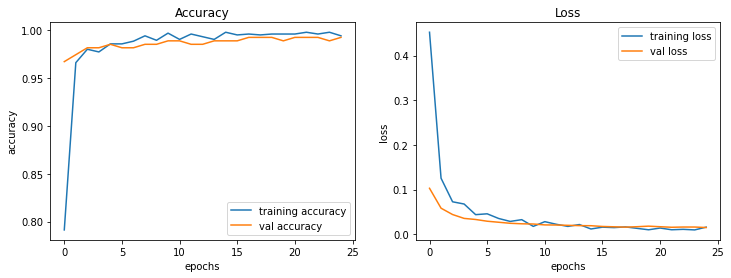

In [22]:
fig = plt.figure(figsize=(12,4))
grid = gridspec.GridSpec(nrows=1,ncols=2,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.savefig("training_history.jpg",dpi=300)

In [4]:
# predict with model
model = create_model(training=False)

# save model architectur as json file
# model_json = model.to_json()
# with open("facemask_mobilenet.json", "w") as json_file:
#     json_file.write(model_json)

model.load_weights("facemask_detection.h5")

C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
W0509 12:06:59.781213  9764 deprecation.py:506] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
## Load model using json file
# json_file = open('facemask_mobilenet.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# model_json = model_from_json(loaded_model_json)
# model_json.load_weights("facemask_detection.h5")

W0509 00:24:26.301068  6104 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0509 00:24:26.401074  6104 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0509 00:24:26.466078  6104 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0509 00:24:26.523081  6104 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0509 00:24:26.584084  6104 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0509 00:24:26.679090  6104 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0509 00:24:26.740093  6104 image.py:709] Clipping input data to the valid range for ims

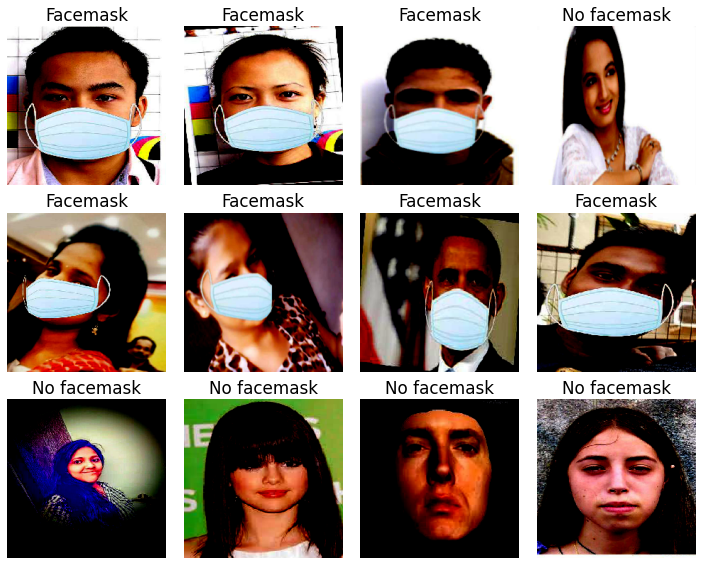

In [114]:
fig=plt.figure(figsize=(10, 8))
plt.rcParams["font.size"]= 14
columns = 4
rows = 3
fig_list= []

for i in range(columns*rows):
    rand = np.random.randint(len(X))
    fig_list.append(fig.add_subplot(rows, columns, i+1))
    img = X[rand]
    plt.axis(False)
    plt.imshow(img)
    prediction = np.argmax(model.predict(img[np.newaxis,:]))
    fig_list[-1].set_title("Facemask" if prediction==0 else "No facemask")
    
plt.tight_layout(True)   
plt.savefig("predict_with_model.jpg",dpi=300)
plt.show()